<a href="https://colab.research.google.com/github/HyberionBrew/skylab_change_prediction/blob/main/net_building_double.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls 

drive  sample_data


In [3]:
!cp drive/MyDrive/Skylab/dataset_middle.zip dataset_middle.zip

In [4]:
%%capture
!unzip dataset_middle.zip

In [5]:
!ls dataset

after  after_label  before  before_label  diff_label  middle  middle_label


In [6]:
#!cp drive/MyDrive/dataset.zip dataset.zip

In [7]:
%%capture
!pip install rasterio
!pip install geopandas
!pip install albumentations==0.4.6

In [8]:
# the precision, dice ... metrics
!git clone https://github.com/hsiangyuzhao/Segmentation-Metrics-PyTorch.git

Cloning into 'Segmentation-Metrics-PyTorch'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 24 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [9]:
!cp Segmentation-Metrics-PyTorch/metric.py metric.py

In [10]:
from metric import BinaryMetrics

In [11]:
!git clone https://github.com/milesial/Pytorch-UNet

Cloning into 'Pytorch-UNet'...
remote: Enumerating objects: 530, done.
remote: Total 530 (delta 0), reused 0 (delta 0), pack-reused 530
Receiving objects: 100% (530/530), 47.40 MiB | 18.38 MiB/s, done.
Resolving deltas: 100% (276/276), done.


In [12]:
!cp -r Pytorch-UNet/unet/ unet/

In [13]:
import sys
import os
sys.path.append(os.path.abspath("unet/*"))
from unet.unet_parts import *
from unet.unet_model import UNet

In [14]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import rasterio as rio
from rasterio import features
from pathlib import Path
import pathlib
import geopandas as gpd
from descartes import PolygonPatch
from PIL import Image
import itertools
import re
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# import imgaug
import random
import albumentations

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

%matplotlib inline

In [15]:
import cv2

In [16]:
total_indx = 2
img1 = cv2.imread('./dataset/before/%06d.png'%total_indx)
img2 = cv2.imread('./dataset/after/%06d.png'%total_indx)
mask1 = torch.load('./dataset/before_label/%06d.pth'%total_indx)
mask2 = torch.load('./dataset/after_label/%06d.pth'%total_indx)
mask_diff = torch.load('./dataset/diff_label/%06d.pth'%total_indx)

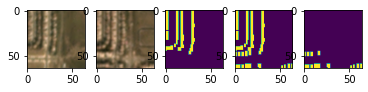

In [17]:
# plt.figure(figsize=(4, 4), dpi=80)
plt.subplot(2, 5, 1)
plt.imshow(img1)

plt.subplot(2, 5, 2)
plt.imshow(img2)

plt.subplot(2, 5, 3)
plt.imshow(mask1)

plt.subplot(2, 5, 4)
plt.imshow(mask2)
plt.subplot(2, 5, 5)
plt.imshow(mask_diff)

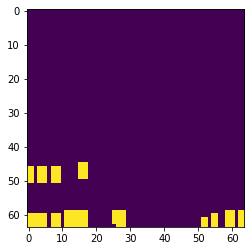

In [18]:
#%%
plt.imshow(mask_diff)

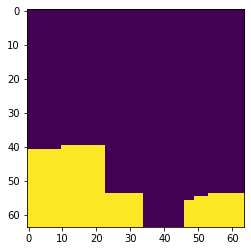

In [19]:
plt.imshow(cv2.GaussianBlur(mask_diff.astype(float),(11, 11), 0) > 0.)

In [20]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [21]:
#%%
import glob

In [22]:
paths = glob.glob('./dataset/before/*')
!ls dataset/

after  after_label  before  before_label  diff_label  middle  middle_label


In [23]:
!mkdir dataset/middle_after_diff
!ls dataset

after	     before	   diff_label  middle_after_diff
after_label  before_label  middle      middle_label


In [24]:
# compute diff label from middle to after
path_middle = glob.glob('./dataset/middle_label/*')
path_after = glob.glob('./dataset/after_label/*')
assert(len(path_middle)==len(path_after))
for i in range(len(path_middle)):
    middle_label = torch.load(path_middle[i])
    after_label = torch.load(path_after[i])
    middle_after_diff = np.logical_xor(middle_label,after_label).astype(np.uint8)
    save_path = str(path_middle[i].replace('middle_label','middle_after_diff'))
    torch.save(middle_after_diff,save_path)

print(f"generated: {len(glob.glob('./dataset/middle_after_diff/*'))}")

generated: 5055


In [68]:
class MyDataset(Dataset):
    def __init__(self, transform=None):
        self.paths = glob.glob('./dataset/before/*')
        self.transform = transform
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_before = cv2.imread(self.paths[idx])
        img_middle = cv2.imread(self.paths[idx].replace('before','middle'))
        img_after = cv2.imread(self.paths[idx].replace('before','after'))

        label_diff_before = torch.load(self.paths[idx].replace('before','diff_label').replace('png','pth'))
        gt_diff_middle = torch.load(self.paths[idx].replace('before','middle_after_diff').replace('png','pth'))
        #label_middle = torch.load(self.paths[idx].replace('before','diff_label').replace('png','pth'))
        # why do we use label2 here?
        #label1 = torch.load(self.paths[idx].replace('before','before_label').replace('png','pth')) 
        label_interest = cv2.GaussianBlur(gt_diff_middle.astype(float),(11, 11), 0) > 0.
        #label1 = cv2.GaussianBlur(label2.astype(float),(11, 11), 0) > 0.
        if self.transform:
            transformed1 = self.transform(image = img_before,label = label_diff_before)
            transformed2 = self.transform(image = img_middle,label = label_interest)
            transformed3 = self.transform(image = img_after,label = gt_diff_middle)
        img_before = transformed1['image']
        label_diff_before = transformed1['label']
        img_middle = transformed2['image']
        label_interest = transformed2['label']
        img_after = transformed3['image']
        gt_diff_middle = transformed3['label']
        return img_before,img_middle,img_after, label_interest,label_diff_before ,gt_diff_middle


In [69]:
transform = A.Compose(
    [
        A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2()
    ]
)

In [70]:
dataset = MyDataset(transform)
img_before,img_middle,img_after, label_interest,gt_diff_before ,gt_diff_middle = dataset[2000]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


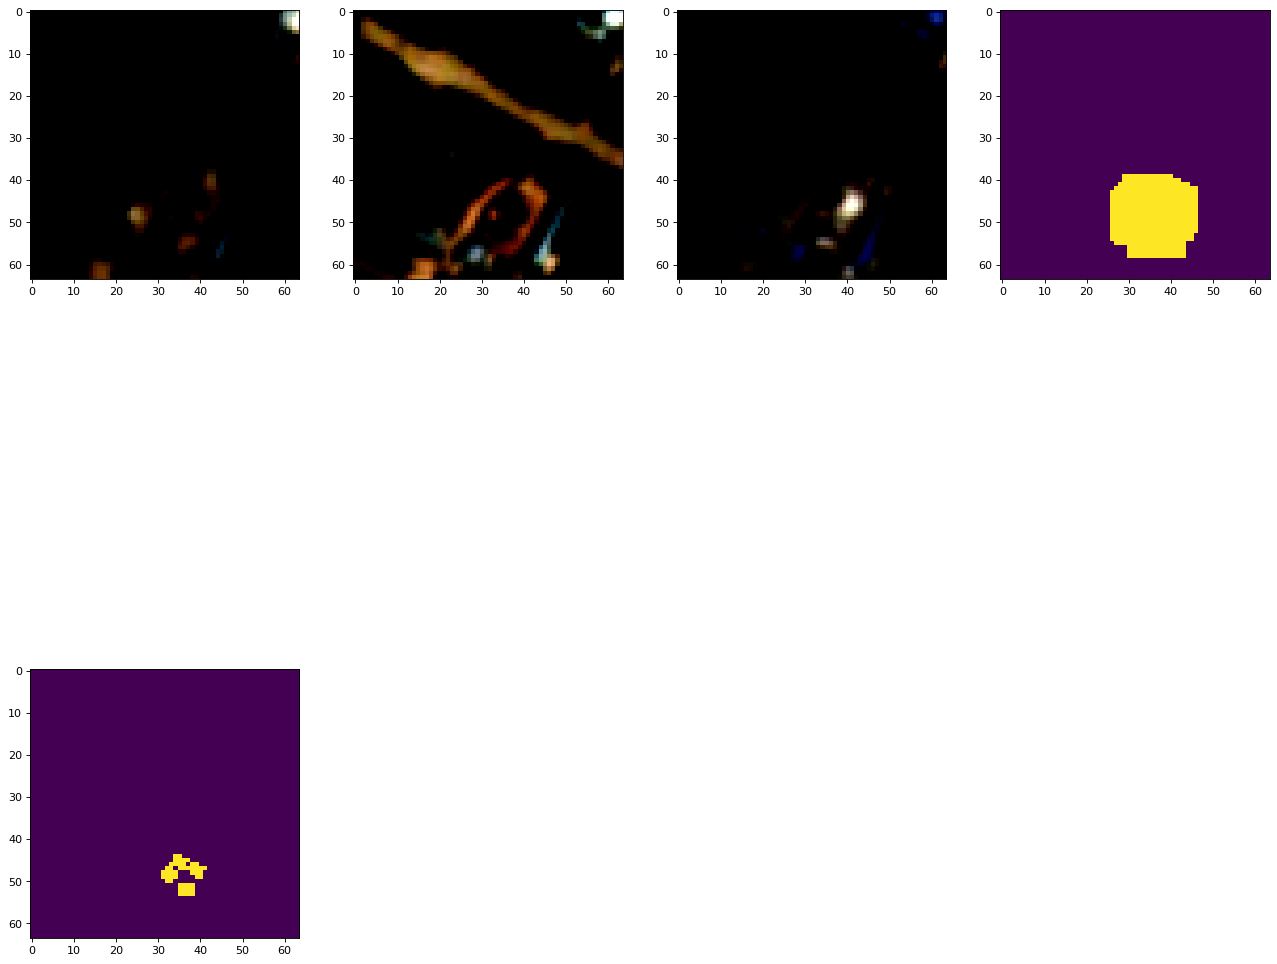

In [71]:
plt.figure(figsize=(20, 20), dpi=80)
plt.subplot(2, 4, 1)
plt.imshow(img_before.permute(1,2,0))

plt.subplot(2, 4, 2)
plt.imshow(img_middle.permute(1,2,0))

plt.subplot(2, 4, 3)
plt.imshow(img_after.permute(1,2,0))

plt.subplot(2, 4, 4)
plt.imshow(label_interest)
plt.subplot(2, 4, 5)
plt.imshow(gt_diff_middle)

In [72]:
from torch.utils.data.sampler import SubsetRandomSampler
import math

train_size = math.floor(0.8 * len(dataset))
test_size = len(dataset)- train_size

np.random.seed(42)
indices = list(range(len(dataset)))
np.random.shuffle(indices)
val_indices,train_indices = indices[train_size:], indices[:train_size]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(val_indices)

batch_size = 32
num_workers = 3
train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
test_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=test_sampler, num_workers=num_workers)

In [73]:
import torch
import numpy as np

import torchvision.transforms.functional as visionF


plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs, label):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    plt.title(label)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = visionF.to_pil_image(img)
        img_gray = np.mean(img, axis=2)
        axs[0, i].imshow(np.asarray(img_gray),cmap=plt.get_cmap('RdYlGn'))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [74]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
def show_batch_images(examples, amount:int, label):
    grid = make_grid(examples)
    show(grid ,label)

In [75]:
#dataloader = DataLoader(dataset, batch_size=8,
#                        shuffle=False, num_workers=3)

In [76]:
def metric(outputs: torch.Tensor, labels: torch.Tensor):
    # y_true: (N, H, W)
    # y_pred: (N, 1, H, W)
    bn = BinaryMetrics()
    metrics = bn(labels,outputs)
    #print(metrics)
    return metrics

In [77]:
!ls 

dataset		    metric.py	  sample_data			utils
dataset_middle.zip  __pycache__   Segmentation-Metrics-PyTorch
drive		    Pytorch-UNet  unet


In [39]:
!mkdir utils
!cp -r Pytorch-UNet/utils/ .
!ls utils


mkdir: cannot create directory ‘utils’: File exists
data_loading.py  dice_score.py	__init__.py  utils.py


In [98]:
from utils.dice_score import dice_loss
pixel_acc_all = []
dice_all = [] 
precision_all = [] 
specificity_all = [] 
recall_all = []

def test_loop(model, test_dataset):
    computeExample = True
    example = np.zeros((batch_size,64,64))
    example_label = torch.tensor(np.zeros((batch_size,64,64)))
    input_label = None
    for img_before,img_middle,img_after, label_interest,gt_diff_before ,gt_diff_middle in tqdm(test_dataset):
        img_before = img_before.type(torch.float32).cuda()
        img_middle = img_middle.type(torch.float32).cuda()
        #img_after = img_after.type(torch.float32).cuda()
        # enable the below to see results with complete input mask
        #label_interest = torch.tensor(np.ones_like(label_interest))
        label_interest = label_interest.cuda()
        #gt_diff_middle = gt_diff_middle.cuda()
        gt_diff_before = gt_diff_middle.cuda()
        with torch.no_grad():
            #sig = torch.nn.Sigmoid()
            
            output = model(torch.cat([img_before,label_interest.unsqueeze(1).type(torch.float32)],dim=1),
                           torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1))
            out_mask = output#output[:,-1,:,:]
            #print(f"outmask {out_mask.shape}")
            #out_mask = sig(out_mask.unsqueeze(1))
        #out_image = output[:,:-1,:,:]
       
         # torch.nn.functional.softmax(out_mask, dim=)
        final_mask = out_mask.cpu() #.detach().numpy()
        #print(f"outmask {final_mask.shape}")
        #final_mask = np.zeros_like(det_mask)
        #final_mask[det_mask>0.5] = 1
        
        pixel_acc, dice, precision, specificity, recall = metric(final_mask,gt_diff_middle.cpu())
        
        pixel_acc_all.append(float(pixel_acc.data.cpu()))
        dice_all.append(float(dice.data.cpu()))
        precision_all.append(float(precision.data.cpu()))
        specificity_all.append(float(specificity.data.cpu()))
        recall_all.append(float(recall.data.cpu()))

        # compute example
        if computeExample:
            sig = torch.nn.Sigmoid()
            final_mask = sig(final_mask)
            final_mask = final_mask.cpu().detach().numpy()
            
            example = np.zeros_like(final_mask)
            #print("----")
            #print(example.shape)
            example[final_mask>0.5] = 1
            computeExample = False
            example_label = gt_diff_middle.unsqueeze(1).cpu()
            input_label = label_interest.unsqueeze(1).cpu()

        
    means = [np.mean(pixel_acc_all), np.mean(dice_all), np.mean(precision_all), np.mean(specificity_all),np.mean(recall_all)]
    print(f"Pixel acc {means[0]}; Dice {means[1]}; Precision {means[2]}; Specifity {means[3]}; Recall{means[4]}")
    #print(example.shape)
    #print("dwd")
    return means, torch.tensor(example), example_label, input_label
        


In [99]:
import torch.nn.functional as F
from utils.dice_score import dice_loss
losses = []
examples = []
metrics_all = []

In [100]:
import torch.nn as nn
from unet.unet_parts import *

class UNet_double_down(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet_double_down, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        
        self.inc_2 = DoubleConv(n_channels, 64)
        self.down1_2 = Down(64, 128)
        self.down2_2 = Down(128, 256)
        self.down3_2 = Down(256, 512)
        self.down4_2 = Down(512, 1024 // factor)

        self.combine1 = nn.Conv2d(128,64,2,padding="same")
        self.combine2 = nn.Conv2d(256,128,2,padding="same")
        self.combine3 = nn.Conv2d(512,256,2,padding="same")
        self.combine4 =nn.Conv2d(1024,512,2,padding="same")
        self.combine5 =nn.Conv2d(2048,1024 // factor,2,padding="same")
        
        
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)


    def forward(self, before, between):
        x1 = self.inc(before)
        #64 channels
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x1_2 = self.inc_2(between)
        x2_2 = self.down1_2(x1_2)
        x3_2 = self.down2_2(x2_2)
        x4_2 = self.down3_2(x3_2)
        x5_2 = self.down4_2(x4_2)
        dim = 1
        #print(x1.shape)
        #print(torch.cat((x1,x1_2),dim=dim).shape)
        x1 = self.combine1(torch.cat((x1,x1_2),dim=dim))
        #print(x1.shape)
        x2 = self.combine2(torch.cat((x2,x2_2),dim=dim))
        x3 = self.combine3(torch.cat((x3,x3_2),dim=dim))
        x4 = self.combine4(torch.cat((x4,x4_2),dim=dim))
        x5 = self.combine5(torch.cat((x5,x5_2),dim=dim))

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [101]:
model2 = UNet_double_down(4,1)
model2.eval()
im1 = torch.ones([1,4,64, 64], dtype=torch.float32)
im2 = torch.ones([1,4,64, 64], dtype=torch.float32)
img_before,img_middle,img_after, label_interest,gt_diff_before, gt_diff_middle = next(iter(train_loader))
output = model2(im1,im2)
print(output.shape)

torch.Size([1, 1, 64, 64])


In [103]:
model = UNet_double_down(4,1).cuda()

#model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)

In [104]:
#optimizer = torch.optim.SGD(model.parameters(),
#                            lr=1e-3,
#                            momentum=4e-5,
#                            weight_decay=0.9)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-5, weight_decay=1e-8, momentum=0.9)

In [105]:
#loss_function = torch.nn.MSELoss().cuda() # 
loss_function = torch.nn.BCEWithLogitsLoss().cuda()

In [106]:

epoch = 30

for e in range(epoch):
    model.train()
    print(f"epoch {e}")
    iters = 0
    losses_epoch = []
    for img_before,img_middle,img_after, label_interest,gt_diff_before, gt_diff_middle in tqdm(train_loader):
        img_before = img_before.type(torch.float32).cuda()
        img_middle = img_middle.type(torch.float32).cuda()
        #img_after = img_after.type(torch.float32).cuda()
        label_interest = label_interest.cuda()
        #gt_diff_middle = gt_diff_middle.cuda()
        gt = gt_diff_middle.cuda().unsqueeze(1).type(torch.float32)
       
        output = model(torch.cat([img_before,label_interest.unsqueeze(1).type(torch.float32)],dim=1),
                       torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1))
        # something is wrong with dice loss
        loss = loss_function(output,gt) #+ dice_loss(F.softmax(output, dim=1).float(),gt, multiclass=False)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(output.grad)
        
        losses_epoch.append(float(loss))
        #break
        if iters%100 == 0:
            #print(float(loss))
            pass
        iters += 1
        #break
    #break
    print(f"Running testing - average loss across epoch: {np.mean(losses_epoch)}")
    losses = np.append(losses, losses_epoch)
    model.eval()
    metrics, example, example_label, input_label = test_loop(model,test_loader)
    print(example_label.shape)
    print(example.shape)
    examples.append((example,example_label,input_label))
    metrics_all.append(metrics)
    #show_batch_images(example,16)
    #show_batch_images(example_label,16)

epoch 0


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.32524519865437757


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.983546169474721; Dice 0.009143216454826242; Precision 0.5763105911523851; Specifity 0.9998930618166924; Recall0.004688945988285391
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 1


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.2166875856598531


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9836356267333031; Dice 0.13920061408469078; Precision 0.5522658582006024; Specifity 0.9982484448701143; Recall0.10199419870884113
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 2


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.16869334747472148


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9836395165572563; Dice 0.13433074050146215; Precision 0.56635066396075; Specifity 0.9984554865707954; Recall0.09287287395155648
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 3


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.1323028144052648


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9840213530696929; Dice 0.25552068789860516; Precision 0.5583722381467187; Specifity 0.996173033490777; Recall0.2570857827622907
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 4


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.10382863726672226


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9846577018499374; Dice 0.33258360549359245; Precision 0.5684265898232311; Specifity 0.9953974958509206; Recall0.3440321609807385
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 5


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.08215106096793348


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9852406227340301; Dice 0.38160090908655464; Precision 0.584890854674466; Specifity 0.9953251133362452; Recall0.3871708624422859
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 6


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.06547478237372684


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.985550981014967; Dice 0.4206771803987787; Precision 0.5892733263429893; Specifity 0.9948572630860976; Recall0.4332307662589474
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 7


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.05286670291400331


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.985938583733514; Dice 0.44698979449178233; Precision 0.6030498440184724; Specifity 0.9949460776988417; Recall0.4531961620355257
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 8


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.043069800596654884


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9863304187440209; Dice 0.4722273507027092; Precision 0.6150510354417149; Specifity 0.9950282172196441; Recall0.4751246178554369
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 9


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.03573429057975923


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9866720641031861; Dice 0.49565856624170507; Precision 0.6219775056312308; Specifity 0.9949561605229974; Recall0.5019819578370637
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 10


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.029465731805351777


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9869686544618823; Dice 0.5112382445294691; Precision 0.6351993154932898; Specifity 0.9951340867714449; Recall0.511045746863447
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 11


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.02513566771595497


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9872741837364932; Dice 0.5281004343007949; Precision 0.6431943344134279; Specifity 0.9951717800771197; Recall0.5276055322207664
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 12


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.021503693651495955


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9875634732441261; Dice 0.5446717589359968; Precision 0.648645551576815; Specifity 0.99513695618281; Recall0.5473666447738185
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 13


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.01915691820097955


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9878133044445089; Dice 0.5571673741947282; Precision 0.6581208449013053; Specifity 0.9952477802123342; Recall0.5567580059191078
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 14


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.017178247147423074


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9880359592537086; Dice 0.5696431567877489; Precision 0.6647047360635351; Specifity 0.9952697293212016; Recall0.5689629099785412
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 15


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0159198680753255


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9882472982862964; Dice 0.5808468912132045; Precision 0.6714239246115601; Specifity 0.9953193278051913; Recall0.5792708689830381
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 16


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.014654724066710378


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9884500697474269; Dice 0.5908212377402675; Precision 0.6767470721502997; Specifity 0.9953512789352852; Recall0.5892950708501588
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 17


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.013660886284609245


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9886427638638351; Dice 0.6006815300517577; Precision 0.6814372345926488; Specifity 0.9953637116899093; Recall0.6001836981536717
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 18


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.013045458709747772


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9888080165378357; Dice 0.6080599415937504; Precision 0.6891899119589321; Specifity 0.9954771176960907; Recall0.6045286046748196
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 19


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.01250923079746504


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9889294588007033; Dice 0.6136913946352868; Precision 0.6956002961767129; Specifity 0.9955737285315991; Recall0.6071673783581051
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 20


  0%|          | 0/127 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

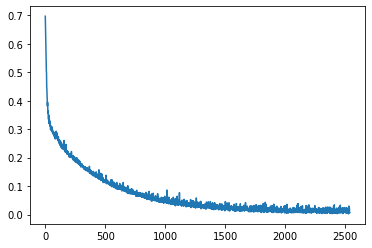

In [107]:
plt.plot(losses)

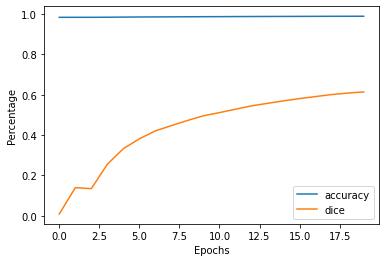

In [108]:
plt.plot([metr[0] for metr in metrics_all], label="accuracy")
plt.plot([metr[1] for metr in metrics_all], label= "dice")
plt.xlabel("Epochs")
plt.ylabel("Percentage")
plt.legend()

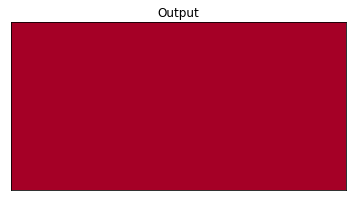

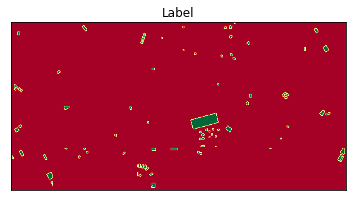

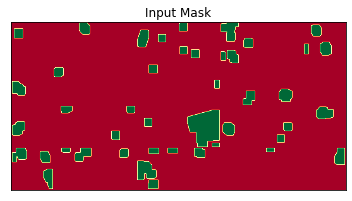

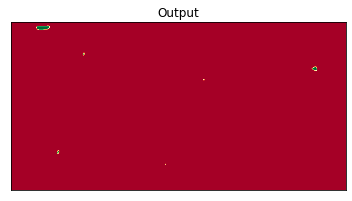

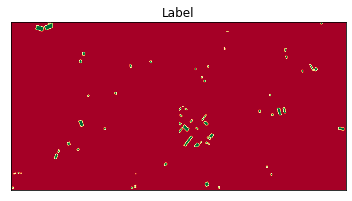

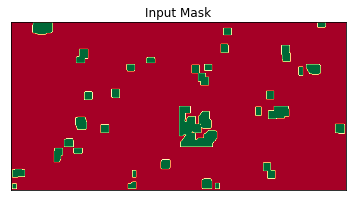

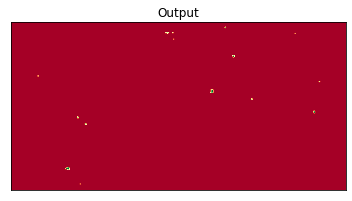

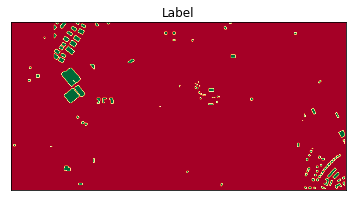

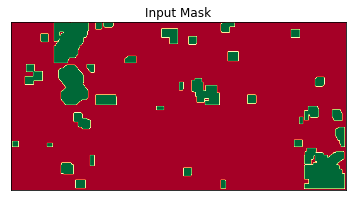

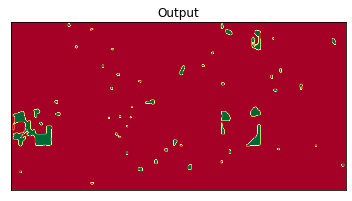

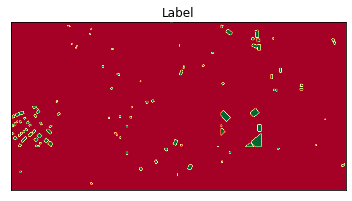

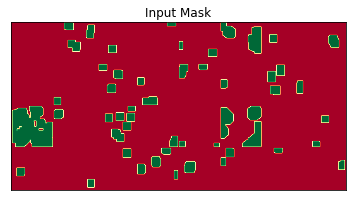

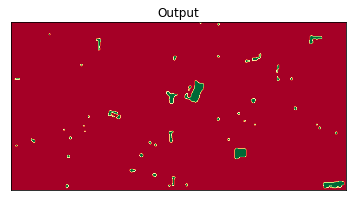

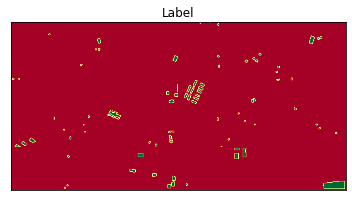

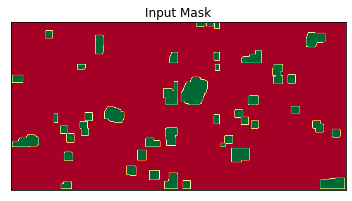

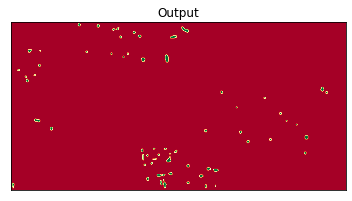

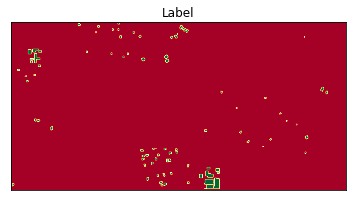

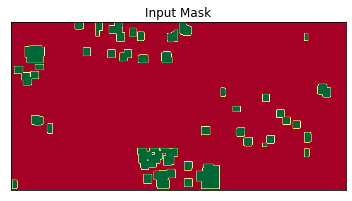

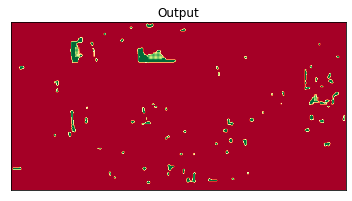

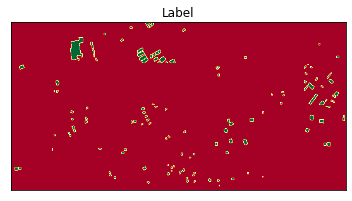

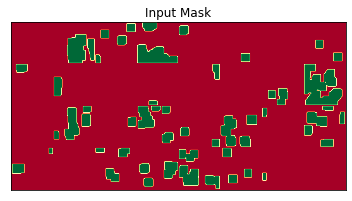

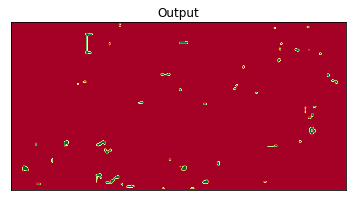

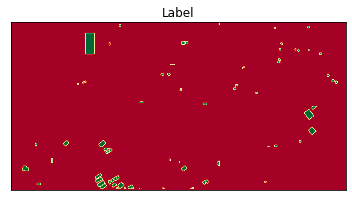

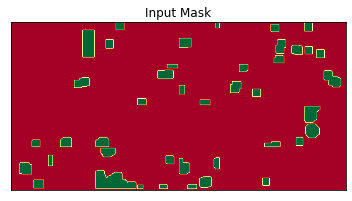

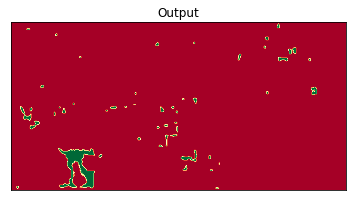

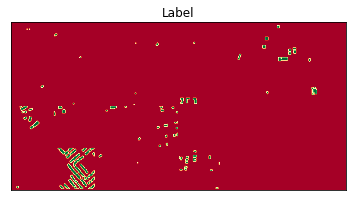

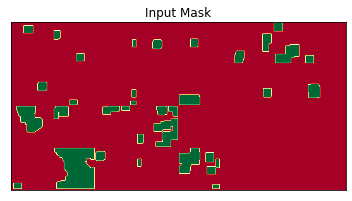

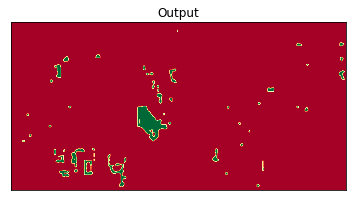

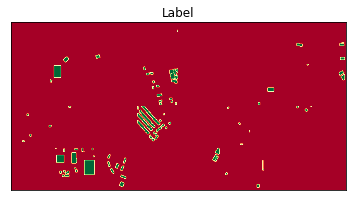

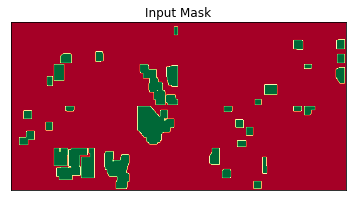

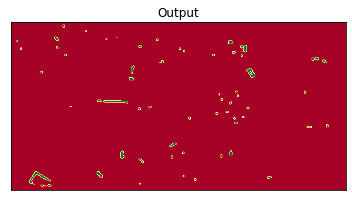

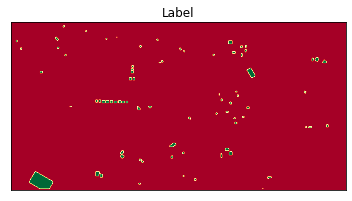

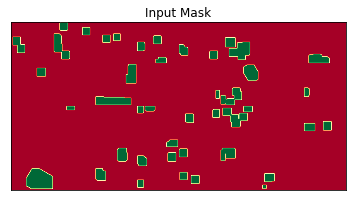

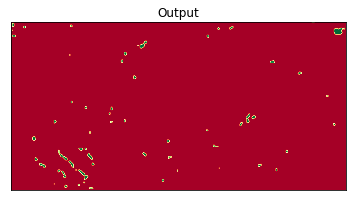

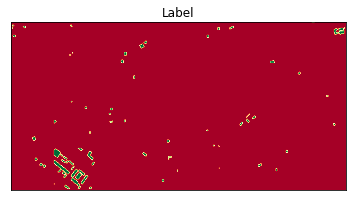

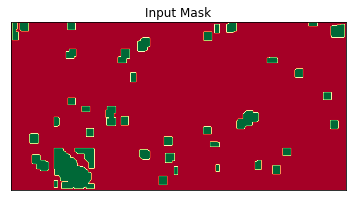

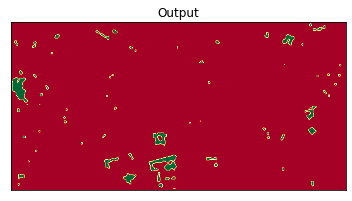

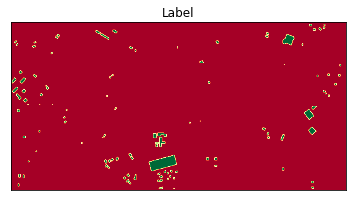

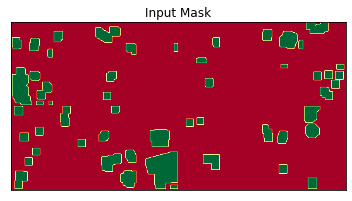

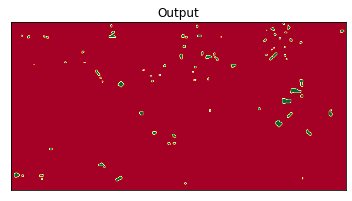

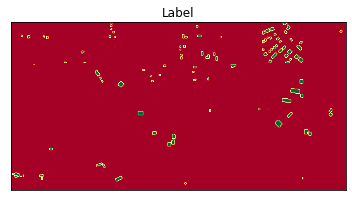

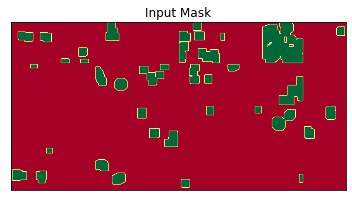

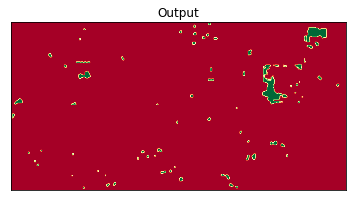

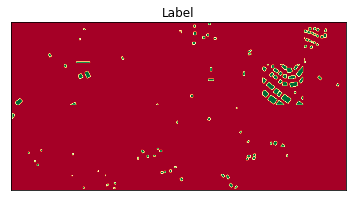

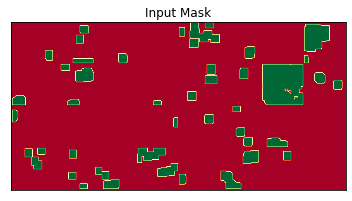

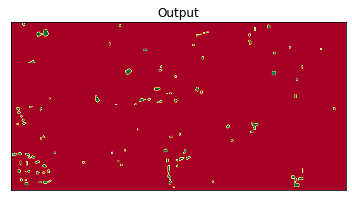

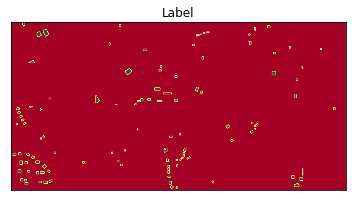

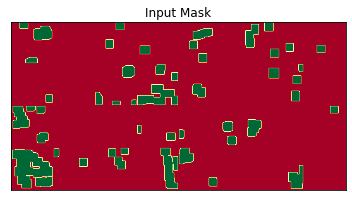

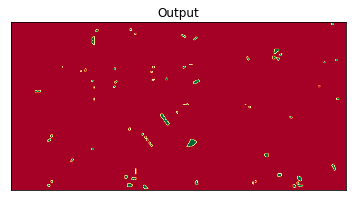

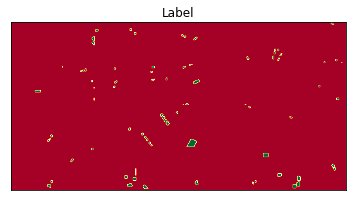

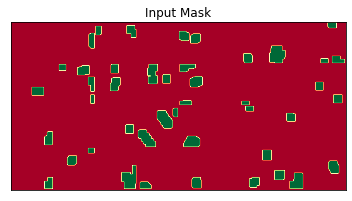

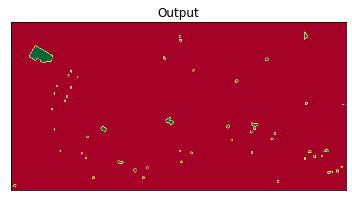

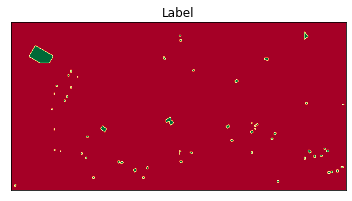

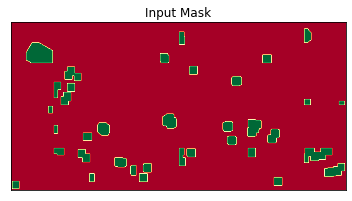

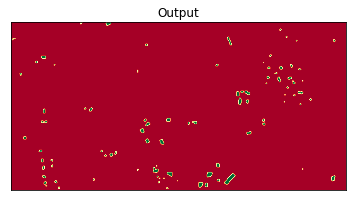

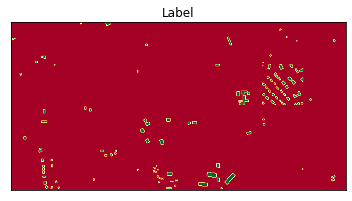

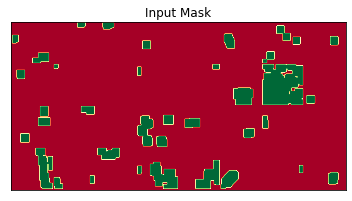

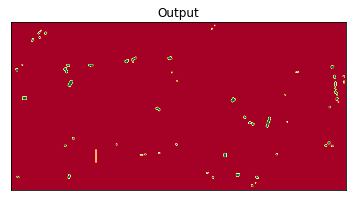

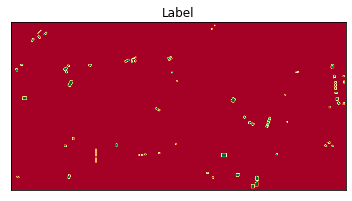

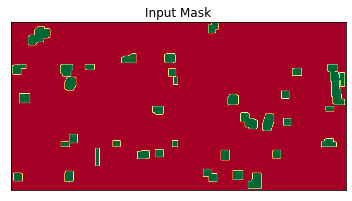

In [109]:
#print(example[0].shape)

for example in examples:
    #print(example[0])
    show_batch_images(example[0],16, "Output")
    show_batch_images(example[1],16, "Label")
    show_batch_images(example[2].type(torch.float32),16, "Input Mask")

In [116]:
from utils.dice_score import dice_loss
pixel_acc_all = []
dice_all = [] 
precision_all = [] 
specificity_all = [] 
recall_all = []

def test_loop_basic(model, test_dataset):
    computeExample = True
    example = np.zeros((batch_size,64,64))
    example_label = torch.tensor(np.zeros((batch_size,64,64)))
    input_label = None
    for img_before,img_middle,img_after, label_interest,gt_diff_before ,gt_diff_middle in tqdm(test_dataset):
        #img_before = img_before.type(torch.float32).cuda()
        img_middle = img_middle.type(torch.float32).cuda()
        #img_after = img_after.type(torch.float32).cuda()
        label_interest = label_interest.cuda()
        gt_diff_before = gt_diff_middle.cuda()
        with torch.no_grad():
            #sig = torch.nn.Sigmoid()
            
            output = model(torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1))
            out_mask = output

        final_mask = out_mask.cpu()
        
        pixel_acc, dice, precision, specificity, recall = metric(final_mask,gt_diff_middle.cpu())
        
        pixel_acc_all.append(float(pixel_acc.data.cpu()))
        dice_all.append(float(dice.data.cpu()))
        precision_all.append(float(precision.data.cpu()))
        specificity_all.append(float(specificity.data.cpu()))
        recall_all.append(float(recall.data.cpu()))

        # compute example
        if computeExample:
            sig = torch.nn.Sigmoid()
            final_mask = sig(final_mask)
            final_mask = final_mask.cpu().detach().numpy()
            
            example = np.zeros_like(final_mask)
            #print("----")
            #print(example.shape)
            example[final_mask>0.5] = 1
            computeExample = False
            example_label = gt_diff_middle.unsqueeze(1).cpu()
            input_label = label_interest.unsqueeze(1).cpu()

        
    means = [np.mean(pixel_acc_all), np.mean(dice_all), np.mean(precision_all), np.mean(specificity_all),np.mean(recall_all)]
    print(f"Pixel acc {means[0]}; Dice {means[1]}; Precision {means[2]}; Specifity {means[3]}; Recall{means[4]}")
    #print(example.shape)
    #print("dwd")
    return means, torch.tensor(example), example_label, input_label
        


In [117]:
basic_model = UNet(4,1).cuda()

#model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)
#optimizer = torch.optim.SGD(model.parameters(),
#                            lr=1e-3,
#                            momentum=4e-5,
#                            weight_decay=0.9)
optimizer = torch.optim.RMSprop(basic_model.parameters(), lr=1e-5, weight_decay=1e-8, momentum=0.9)

In [118]:
#loss_function = torch.nn.MSELoss().cuda() # 
loss_function = torch.nn.BCEWithLogitsLoss().cuda()

In [119]:
losses_basic = []
examples_basic = []
metrics_all_basic = []
epoch = 30

for e in range(epoch):
    basic_model.train()
    print(f"epoch {e}")
    iters = 0
    losses_epoch_basic = []
    for img_before,img_middle,img_after, label_interest,gt_diff_before, gt_diff_middle in tqdm(train_loader):
        # img_before = img_before.type(torch.float32).cuda()
        img_middle = img_middle.type(torch.float32).cuda()
        label_interest = label_interest.cuda()
        gt = gt_diff_middle.cuda().unsqueeze(1).type(torch.float32)
       
        output = basic_model(torch.cat([img_middle,label_interest.unsqueeze(1).type(torch.float32)],dim=1))
        # something is wrong with dice loss
        loss = loss_function(output,gt) #+ dice_loss(F.softmax(output, dim=1).float(),gt, multiclass=False)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_epoch_basic.append(float(loss))
        if iters%100 == 0:
            #print(float(loss))
            pass
        iters += 1

    print(f"Running testing - average loss across epoch: {np.mean(losses_epoch_basic)}")
    losses_basic = np.append(losses_basic, losses_epoch_basic)
    basic_model.eval()
    metrics, example, example_label, input_label = test_loop_basic(basic_model,test_loader)
    print(example_label.shape)
    print(example.shape)
    examples_basic.append((example,example_label,input_label))
    metrics_all_basic.append(metrics)
    #show_batch_images(example,16)
    #show_batch_images(example_label,16)

epoch 0


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.3173668733027976


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9785002786666155; Dice 0.30595766799524426; Precision 0.33829296194016933; Specifity 0.9898978359997272; Recall0.2967891797889024
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 1


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.21015515759235293


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9808682268485427; Dice 0.17765563857550185; Precision 0.4240537597266325; Specifity 0.994636595249176; Recall0.16236617140488785
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 2


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.16429969187327256


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9814824306716522; Dice 0.14870303945992708; Precision 0.4089153647689348; Specifity 0.9959148180981477; Recall0.12713682885389987
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 3


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.1304218373078061


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9823466883972287; Dice 0.20544323627188293; Precision 0.45081834585542424; Specifity 0.9960569855757058; Recall0.16968921037239182
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 4


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.10386467953835886


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9829729933291673; Dice 0.29170699137675354; Precision 0.47223170136769566; Specifity 0.9947026677429676; Recall0.28636370171485226
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 5


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.08317084622195386


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9831195315346122; Dice 0.3460129671686854; Precision 0.4815905593779348; Specifity 0.9935146365314722; Recall0.36570714895822837
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 6


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.06739030977872414


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.983519867594753; Dice 0.39126143537623254; Precision 0.4922341490012546; Specifity 0.9928306397050619; Recall0.4318632184173229
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 7


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.05474765874504104


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9841163516975939; Dice 0.424514082490017; Precision 0.5118426541897776; Specifity 0.9929602679330856; Recall0.4620990011647212
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 8


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.045202644028532225


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9846074314167103; Dice 0.44926541888177174; Precision 0.527528023438928; Specifity 0.9930997484674057; Recall0.4836058551480256
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 9


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.037890311139892406


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9849973689764738; Dice 0.47125508784988324; Precision 0.5414623350730039; Specifity 0.9931956311687827; Recall0.5036646884897247
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 10


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.03188575499170408


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9854130253873088; Dice 0.49074414558472773; Precision 0.555237919336512; Specifity 0.9933231476355683; Recall0.5210627096479494
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 11


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.02729706866593342


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9858063113254806; Dice 0.5053991357929492; Precision 0.5739332925594928; Specifity 0.9936582160492738; Recall0.5272319505482824
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 12


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.023684189530221497


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.986162549457871; Dice 0.5210546800273641; Precision 0.5861162595512391; Specifity 0.9938215187822397; Recall0.5406733421059674
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 13


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.021120647437811838


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9864939781171935; Dice 0.5340435226828484; Precision 0.5982393885088462; Specifity 0.9940014569354909; Recall0.5501927555161853
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 14


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.018985622914463984


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9867918020735185; Dice 0.5467269183429664; Precision 0.6081648839566772; Specifity 0.9941221131632726; Recall0.5612142520667046
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 15


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.01701056566749384


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9870742103084922; Dice 0.5576584298380265; Precision 0.6205766372665451; Specifity 0.9943115278147161; Recall0.5673888408365594
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 16


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0157586268523312


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9873181310865808; Dice 0.567305557099562; Precision 0.6325597504967859; Specifity 0.9945052567431155; Recall0.5723895596577779
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 17


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.01499519885084995


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9875142517396145; Dice 0.5743824600538103; Precision 0.6438814656646438; Specifity 0.9947005082956619; Recall0.5743209677248307
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 18


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.014273258267102514


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9877243437069027; Dice 0.5818814504877977; Precision 0.6532896258567247; Specifity 0.9948561915049428; Recall0.5784189968729434
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 19


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.013487426103936054


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9878996565937996; Dice 0.5881943444708426; Precision 0.6623604508529354; Specifity 0.9949976800009608; Recall0.5808404984433897
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 20


  0%|          | 0/127 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

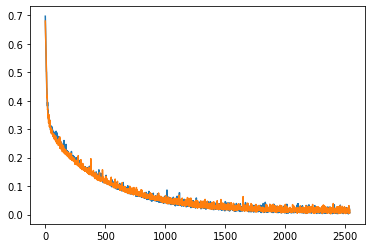

In [120]:
plt.plot(losses)
plt.plot(losses_basic)

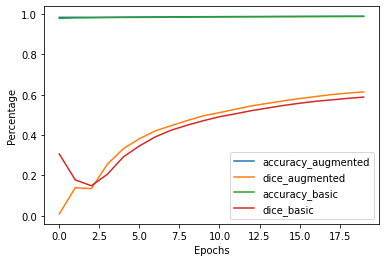

In [121]:
plt.plot([metr[0] for metr in metrics_all], label="accuracy_augmented")
plt.plot([metr[1] for metr in metrics_all], label= "dice_augmented")
plt.plot([metr[0] for metr in metrics_all_basic], label="accuracy_basic")
plt.plot([metr[1] for metr in metrics_all_basic], label= "dice_basic")
plt.xlabel("Epochs")
plt.ylabel("Percentage")
plt.legend()

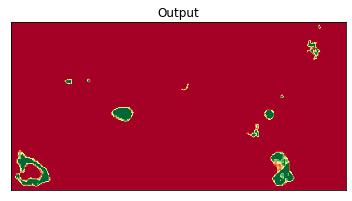

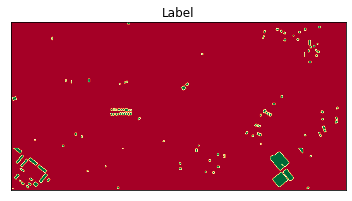

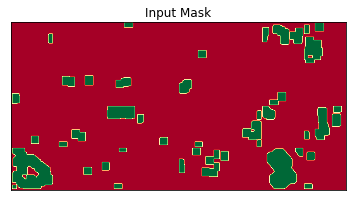

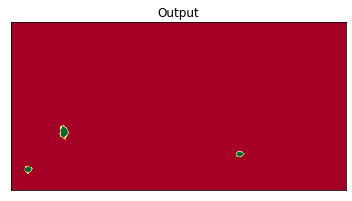

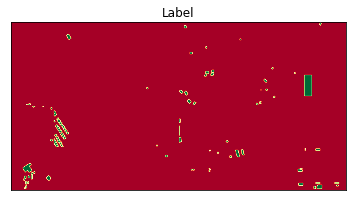

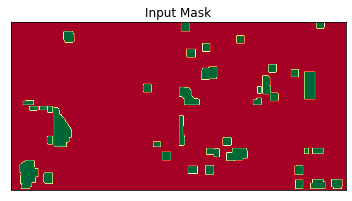

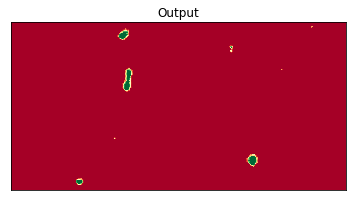

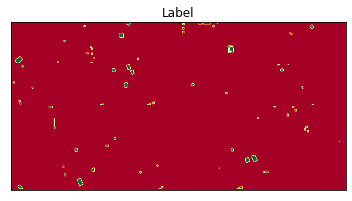

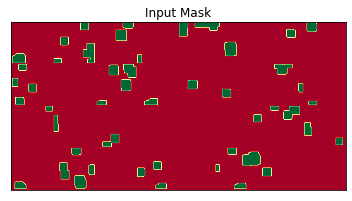

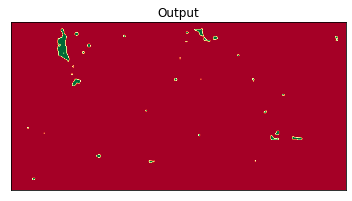

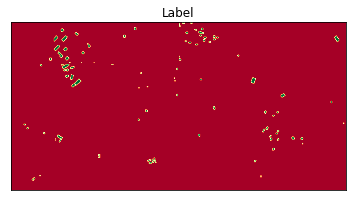

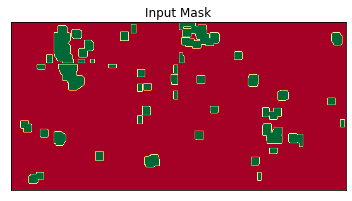

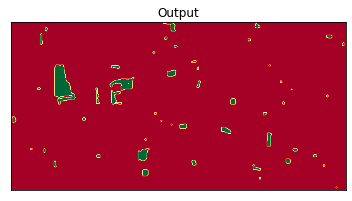

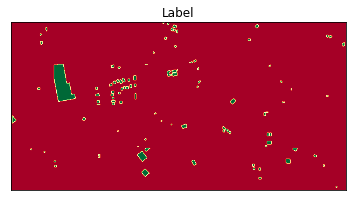

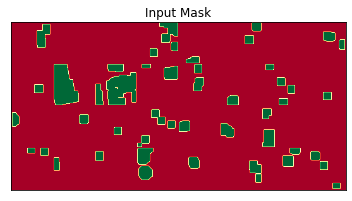

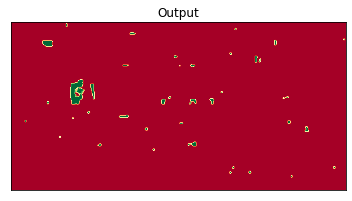

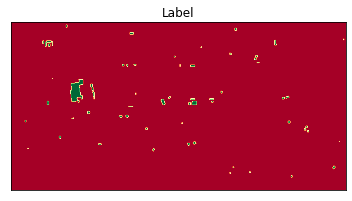

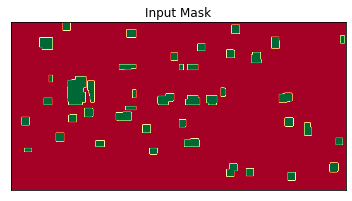

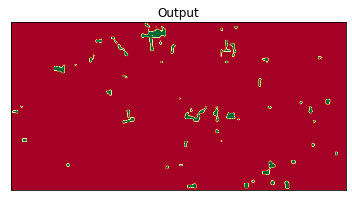

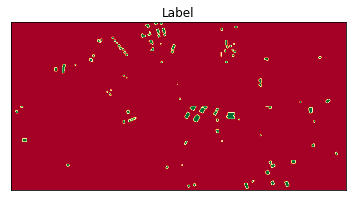

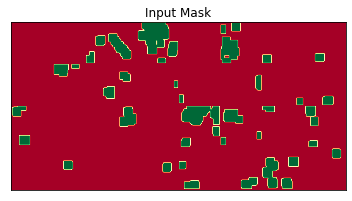

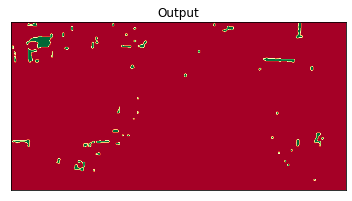

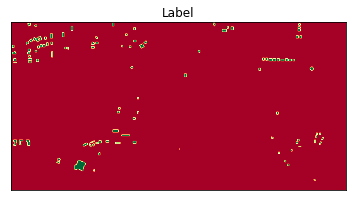

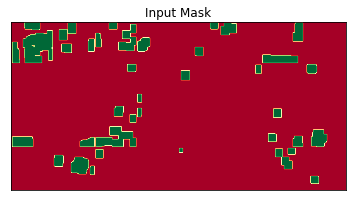

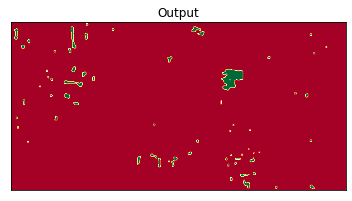

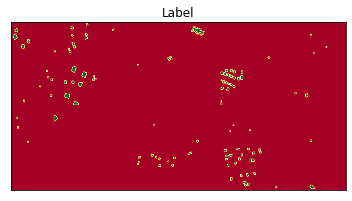

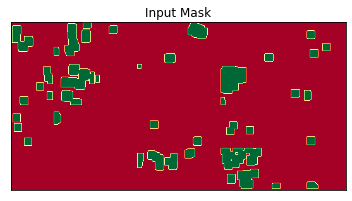

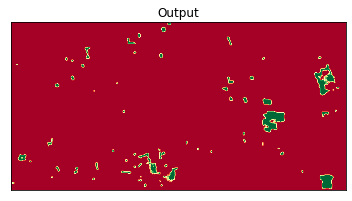

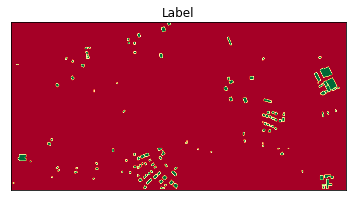

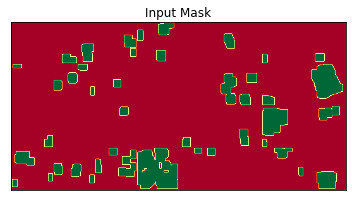

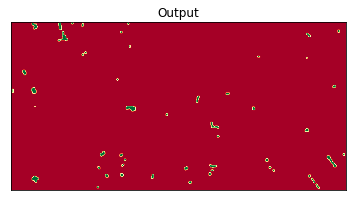

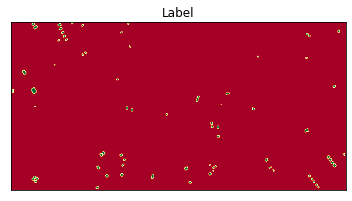

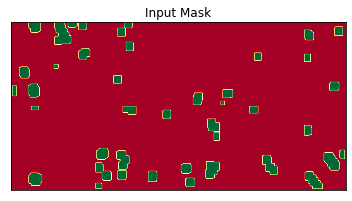

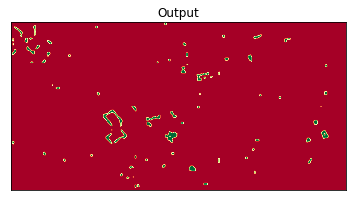

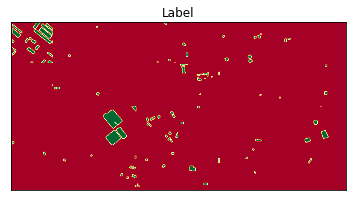

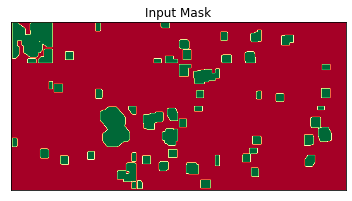

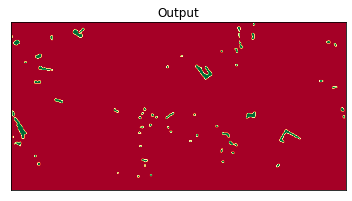

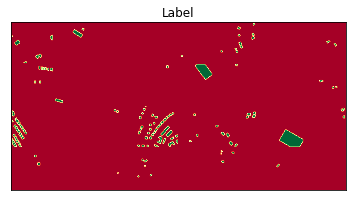

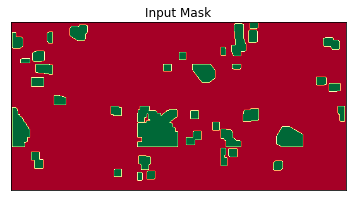

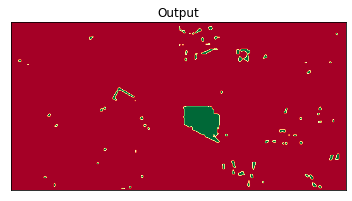

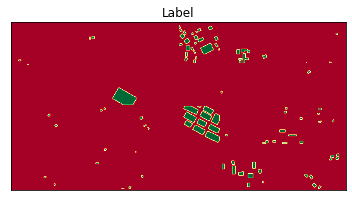

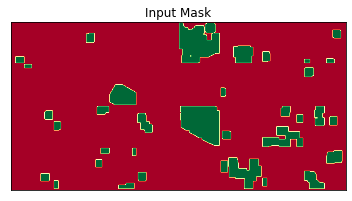

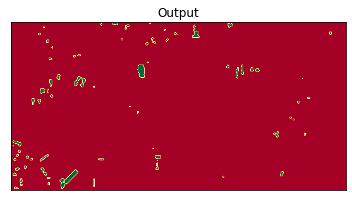

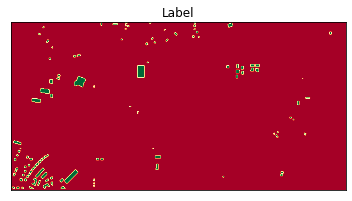

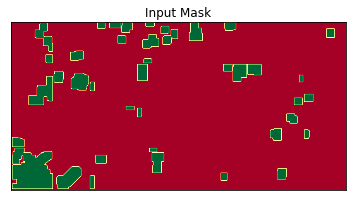

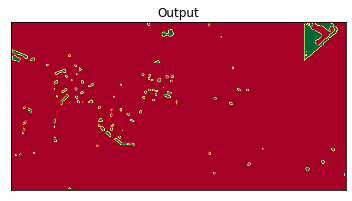

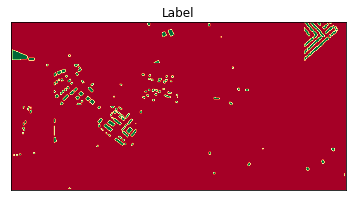

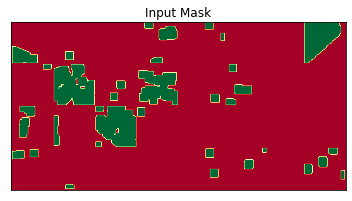

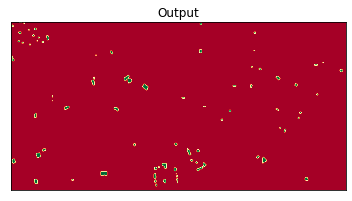

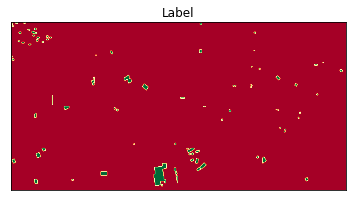

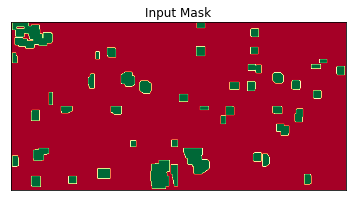

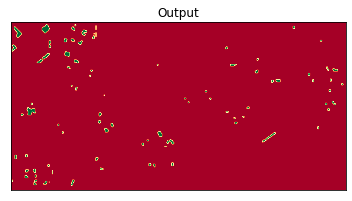

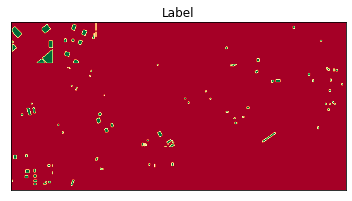

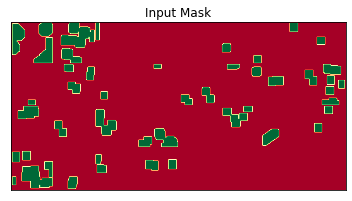

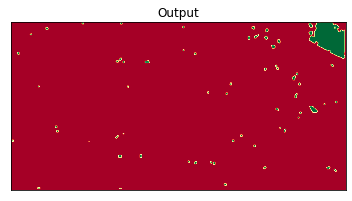

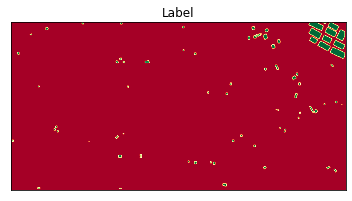

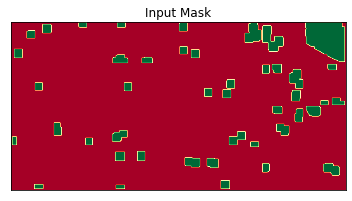

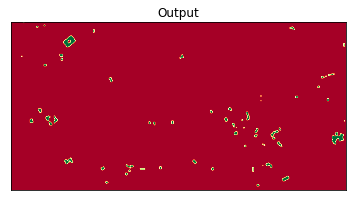

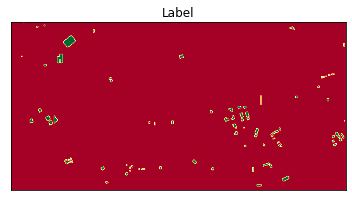

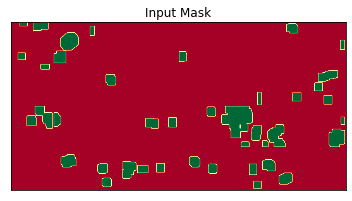

In [122]:
#print(example[0].shape)

for example in examples_basic:
    #print(example[0])
    show_batch_images(example[0],16, "Output")
    show_batch_images(example[1],16, "Label")
    show_batch_images(example[2].type(torch.float32),16, "Input Mask")